In [7]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/data/user_ratings.csv')
df = df[['Username','BGGId','Rating']]
game_df = pd.read_csv('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/data/games.csv')

In [4]:
df['Username'] = df['Username'].astype(str)
df['BGGId'] = df['BGGId'].astype(int)
df['Rating'] = df['Rating'].astype('float32')

In [31]:
user_ids = df['Username'].unique().tolist()
game_ids = df['BGGId'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
game2game_encoded = {x: i for i,x in enumerate(game_ids)}
num_users = len(user2user_encoded)
num_games = len(game2game_encoded)

In [32]:
df['user'] = df['Username'].map(user2user_encoded)
df['game'] = df['BGGId'].map(game2game_encoded)
df['Rating'] = df['Rating'].values.astype(np.float32)

In [35]:
X = df[['user','game']].values
y = df[['Rating']]
scaler = MinMaxScaler()
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)
y_train, y_test = scaler.fit_transform(y_train), scaler.transform(y_test)

In [33]:
embed_size = 50

#input layer
user_in = Input(name='user_in', shape=(1,))
prod_in = Input(name='prod_in', shape=(1,))


#matrix factorization
mf_user_emb = Embedding(name='mf_user_emb', input_dim=num_users, output_dim = embed_size)(user_in)
mf_user_flat = Flatten(name='mf_user_flat')(mf_user_emb)
mf_prod_emb = Embedding(name='mf_prod_emb', input_dim=num_games, output_dim=embed_size)(prod_in)
mf_prod_flat = Flatten(name='mf_prod_flat')(mf_prod_emb)
mf_dot = Dot(name='mf_dot', normalize=True, axes=1)([mf_user_flat, mf_prod_flat])

#neural network
nn_user_emb = Embedding(name='nn_user_emb', input_dim = num_users, output_dim = embed_size)(user_in)
nn_user_flat = Flatten(name='nn_user_flat')(nn_user_emb)
nn_prod_emb = Embedding(name='nn_prod_emb', input_dim=num_games, output_dim= embed_size)(prod_in)
nn_prod_flat = Flatten(name='nn_prod_flat')(nn_prod_emb)
nn_concat = Concatenate()([nn_user_flat, nn_prod_flat])
nn_dense = Dense(name='nn_dense', units=int(embed_size/2), activation='relu')(nn_concat)

#Merge both together
combo = Concatenate()([mf_dot, nn_dense])
y_out = Dense(name='y_out', units=1, activation='linear')(combo)

model = Model(inputs=[user_in, prod_in], outputs = y_out, name='neural_cf')
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])


In [36]:
history = model.fit(x=[x_train[:,0], x_train[:,1]], y=y_train, epochs=3, batch_size = 5000, verbose=True)

Epoch 1/3
3031/3031 [==============================] - 1234s 407ms/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 2/3
3031/3031 [==============================] - 1217s 401ms/step - loss: 0.0135 - mean_squared_error: 0.0135
Epoch 3/3
3031/3031 [==============================] - 1234s 407ms/step - loss: 0.0112 - mean_squared_error: 0.0112


Text(0.5, 0, 'epoch')

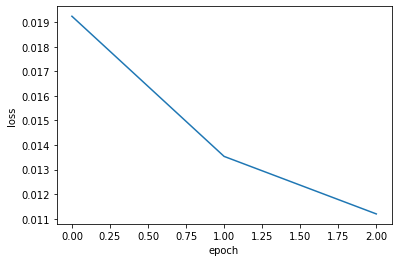

In [37]:
plt.plot(history.history['loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

In [38]:
y_pred = model.predict(x=[x_test[:,0], x_test[:,1]])
mean_squared_error(y_test, y_pred, squared=False)

118389/118389 [==============================] - 89s 750us/step


0.116958246

In [39]:
model.save('C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/nn_model_2')

INFO:tensorflow:Assets written to: C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/nn_model_2\assets


INFO:tensorflow:Assets written to: C:/Users/John/Documents/LHL Lecture Material/boardgame-recommender/src/models/nn_model_2\assets


In [40]:
def user_recommendations(user, n_games,model):
    """
        Takes in a user, n_games and a model to returns their top n_games recommendations that they have not rated yet.

        Parameters:
            user(str): name of user
            n_games(int): number of games to show
            model: the model to use for predictions
            
        Returns:
            A list with each game as an index with a column for their estimated rating
    """
    # Remove the boardgames that the user have rated
    boardgame_id = df['BGGId'].unique()
    user_list = df.loc[df['Username']==user, 'BGGId']
    user_list = np.setdiff1d(boardgame_id, user_list)

    # Create sparse dataset with username and bggid
    testset = np.array([[user2user_encoded[user], game2game_encoded[bggid]] for bggid in user_list])
    # Test model on the testset and determine the boardgames with the highest rating
    predictions = model.predict(x=[testset[:,0],testset[:,1]])
    # Reshaped the predictions array by Transposing it. 
    top_ratings_idx = predictions.T[0].argsort()[::-1][:n_games]
    bgg_ids = user_list[top_ratings_idx]
    bgg_name = [game_df.loc[game_df['BGGId'] ==id]['Name'].values[0] for id in bgg_ids]
    print(f'Top boardgames for {user} in order are: \n {bgg_name}')

In [41]:
user_recommendations('bennygui',5, model)

673/673 [==============================] - 1s 726us/step
Top boardgames for bennygui in order are: 
 ['Final Girl', 'Ark Nova', 'Great Western Trail (Second Edition)', 'High Noon', 'Chronicles of Crime: 2400']


In [47]:
games = df[df['Username'] == 'bennygui'].sort_values('Rating',ascending=False)['BGGId'].values[:5]

In [48]:
for game in games:
    print(game_df[game_df['BGGId']==game]['Name'].values[0])

Five Tribes
Jaipur
Isle of Skye: From Chieftain to King
7 Wonders
Marco Polo II: In the Service of the Khan
